In [18]:
import pandas as pd 
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import log_loss, classification_report
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.model_selection import StratifiedKFold

from lightgbm import LGBMClassifier
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier

import warnings
warnings.filterwarnings('ignore')

In [2]:
train = pd.read_csv('./open/train.csv', index_col='index').reset_index(drop=True)
test = pd.read_csv('./open/test.csv', index_col='index').reset_index(drop=True)

In [3]:
train['UNEMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0)
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

test['UNEMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 1 if x>0 else 0)
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].map(lambda x: 0 if x>0 else x)

In [6]:
train['occyp_type'] = train['occyp_type'].fillna('None')
test['occyp_type'] = test['occyp_type'].fillna('None')

In [19]:
# train['income_edu'] = train['income_type'] + train['edu_type']
# test['income_edu'] = test['income_type'] + test['edu_type']


# train['occyp_type'] = train['occyp_type'].fillna('None')
# test['occyp_type'] = test['occyp_type'].fillna('None')

# train['income_occyp'] = train['income_type'] + train['occyp_type']
# test['income_occyp'] = test['income_type'] + test['occyp_type']


# train['occyp_edu'] = train['occyp_type'] + train['edu_type']
# test['occyp_edu'] = test['occyp_type'] + test['edu_type']

In [4]:
train['phone_total'] = train['FLAG_MOBIL'] + train['work_phone'] + train['phone']
test['phone_total'] = test['FLAG_MOBIL'] + test['work_phone'] + test['phone']

In [7]:
CATEGORY_COL = [col for col in train.columns if train[col].dtype == 'object']

In [8]:
# CATEGORY_COL = ['gender', 'car', 'reality', 'email', 'family_type', 'house_type', 'UNEMPLOYED', 'income_edu', 'income_occyp', 'occyp_edu']
# CATEGORY_COL = ['gender', 'car', 'reality', 'income_edu', 'UNEMPLOYED', 'family_type', 'house_type', 'income_type', 'edu_type', 'family_house']
NUMERIC_COL = ['child_num', 'income_total', 'DAYS_EMPLOYED', 'family_size', 'begin_month', 'DAYS_BIRTH', 'phone_total']

FEATURES = CATEGORY_COL + NUMERIC_COL
TARGET = ['credit']

train = train[FEATURES+TARGET]
test = test[FEATURES]

In [10]:
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures()
ohe = OneHotEncoder(handle_unknown='ignore')

ohe.fit(train.loc[:, CATEGORY_COL])

train_onehot_df = pd.DataFrame(ohe.transform(train.loc[:,CATEGORY_COL]).toarray(), 
                               columns=ohe.get_feature_names(CATEGORY_COL))
train = train.drop(CATEGORY_COL, axis=1)

train_onehot_df = pd.DataFrame(poly.fit_transform(train_onehot_df), 
                               columns=poly.get_feature_names())

train = pd.concat([train, train_onehot_df], axis=1)

In [11]:
test_onehot_df = pd.DataFrame(ohe.transform(test.loc[:,CATEGORY_COL]).toarray(), 
                              columns=ohe.get_feature_names(CATEGORY_COL))
test = test.drop(CATEGORY_COL, axis=1)
test_onehot_df = pd.DataFrame(poly.transform(test_onehot_df),
                              columns=poly.get_feature_names())
test = pd.concat([test, test_onehot_df], axis=1)

In [12]:
print(train.shape)
print(test.shape)

(26457, 1136)
(10000, 1135)


In [13]:
param = {'max_depth':10, 
#          'num_leaves':128,
         'objective': 'multi-class',
         'n_estimators':2000, 
         'learning_rate':0.05, 
         'subsample':0.7, 
         'colsample_bytree':0.7}

In [14]:
FEATURES = [col for col in train.columns if col!='credit']

In [15]:
param

{'max_depth': 10,
 'objective': 'multi-class',
 'n_estimators': 2000,
 'learning_rate': 0.05,
 'subsample': 0.7,
 'colsample_bytree': 0.7}

In [16]:
oof_lgb = np.zeros((len(train),3))
lgb_pred = np.zeros((len(test),3))
feature_importance_df = pd.DataFrame()

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    clf = LGBMClassifier(**param)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            early_stopping_rounds=100,
            verbose=100)
    
    oof_lgb[val_idx] = clf.predict_proba(X_valid, num_iteration=clf.best_iteration_)    
    lgb_pred += clf.predict_proba(test[FEATURES], num_iteration=clf.best_iteration_)

lgb_pred /= 5    
print('\nCross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_lgb)))


fold num_: 0
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.717877	valid_1's multi_logloss: 0.773725
[200]	training's multi_logloss: 0.664212	valid_1's multi_logloss: 0.755255
[300]	training's multi_logloss: 0.620323	valid_1's multi_logloss: 0.744471
[400]	training's multi_logloss: 0.582752	valid_1's multi_logloss: 0.735973
[500]	training's multi_logloss: 0.552014	valid_1's multi_logloss: 0.730962
[600]	training's multi_logloss: 0.523445	valid_1's multi_logloss: 0.728119
[700]	training's multi_logloss: 0.498498	valid_1's multi_logloss: 0.727337
Early stopping, best iteration is:
[645]	training's multi_logloss: 0.511996	valid_1's multi_logloss: 0.727085

fold num_: 1
Training until validation scores don't improve for 100 rounds
[100]	training's multi_logloss: 0.711882	valid_1's multi_logloss: 0.77846
[200]	training's multi_logloss: 0.656972	valid_1's multi_logloss: 0.761157
[300]	training's multi_logloss: 0.613145	valid_1's multi_logloss

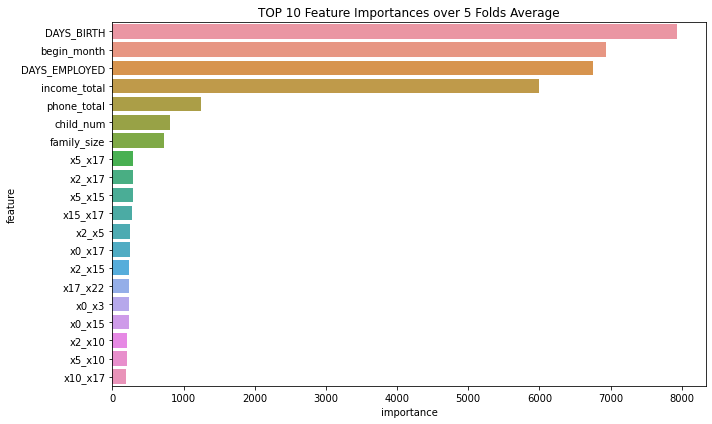

In [17]:
feature_importance = pd.DataFrame({'feature':clf.feature_name_, 'importance':clf.feature_importances_})

plt.figure(figsize=(10,6))
sns.barplot(x='importance', 
            y='feature', 
            data=feature_importance.sort_values(by="importance", ascending=False).reset_index()[:20])

plt.title('TOP 10 Feature Importances over 5 Folds Average')
plt.tight_layout()

In [21]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+cat_pred)/2
submit.to_csv('./baseline.csv', index=False)

In [22]:
submit

,index,0,1,2
0,26457,0.054502,0.092193,0.853305
1,26458,0.171130,0.150883,0.677987
2,26459,0.056195,0.127827,0.815978
3,26460,0.093781,0.097098,0.809121
4,26461,0.076979,0.150916,0.772105
...,...,...,...,...
9995,36452,0.119955,0.274973,0.605072
9996,36453,0.196299,0.253860,0.549841
9997,36454,0.018709,0.074719,0.906572
9998,36455,0.154024,0.228205,0.617771


In [20]:
model = CatBoostClassifier(loss_function='MultiClass', 
                           depth = 10,
                           early_stopping_rounds=100,
                           task_type="GPU",
                           random_state=42,
                           learning_rate=0.05,
                           iterations=5000)

skf = StratifiedKFold(n_splits=5, random_state=74, shuffle=True)


oof_cat = np.zeros((len(train), 3))
cat_pred = np.zeros((len(test), 3))


for idx, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    _train = Pool(X_train, label=y_train)
    _valid = Pool(X_valid, label=y_valid)
    
    print( "\nFold ", idx)
    fit_model = model.fit(_train,
                          eval_set=_valid,
                          use_best_model=True,
                          verbose=200
                         )
    pred = fit_model.predict_proba(X_valid)
    print( "  Log loss = ", log_loss(y_valid, pred) )
    oof_cat[val_idx] = pred
    cat_pred += fit_model.predict_proba(test[FEATURES])
cat_pred /= 5
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_cat)))


Fold  0
0:	learn: 1.0700296	test: 1.0705595	best: 1.0705595 (0)	total: 21.5ms	remaining: 1m 47s
200:	learn: 0.6981571	test: 0.7673242	best: 0.7673242 (200)	total: 3.16s	remaining: 1m 15s
400:	learn: 0.6228178	test: 0.7494923	best: 0.7494923 (400)	total: 6.29s	remaining: 1m 12s
600:	learn: 0.5667685	test: 0.7414065	best: 0.7414065 (600)	total: 9.48s	remaining: 1m 9s
800:	learn: 0.5224706	test: 0.7378679	best: 0.7378602 (799)	total: 12.7s	remaining: 1m 6s
1000:	learn: 0.4866996	test: 0.7375929	best: 0.7372441 (936)	total: 15.9s	remaining: 1m 3s
bestTest = 0.7371411889
bestIteration = 1048
Shrink model to first 1049 iterations.
  Log loss =  0.7371412448738954

Fold  1
0:	learn: 1.0700820	test: 1.0702363	best: 1.0702363 (0)	total: 17.1ms	remaining: 1m 25s
200:	learn: 0.7080971	test: 0.7624551	best: 0.7624551 (200)	total: 3.23s	remaining: 1m 17s
400:	learn: 0.6297391	test: 0.7400095	best: 0.7400095 (400)	total: 6.4s	remaining: 1m 13s
600:	learn: 0.5740193	test: 0.7285314	best: 0.7285314 (

In [34]:
from xgboost import XGBClassifier

xgb_params={'learning_rate':0.05,
            'booster': 'gbdt',
            'max_depth':10,
            'objective':'multi:softprob',
            'num_class':3,
            'subsample':0.7,
            'colsample_bytree':0.7,
            'random_state':42,
            'tree_method':'gpu_hist',
            'gpu_id': 0,
            'n_jobs': -1,
            'predictor':'gpu_predictor'}

In [40]:
oof_xgb = np.zeros((len(train),3))
xgb_pred = np.zeros((len(test),3))

skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=55)

for fold_, (trn_idx, val_idx) in enumerate(skf.split(train, train['credit'])):
    print("\nfold num_: {}".format(fold_))
    y_train, y_valid = train.iloc[trn_idx][TARGET], train.iloc[val_idx][TARGET]
    X_train, X_valid = train.iloc[trn_idx][FEATURES], train.iloc[val_idx][FEATURES]
    
    clf = XGBClassifier(**param)
    clf.fit(X_train, y_train, 
            eval_set=[(X_train, y_train), (X_valid, y_valid)], 
            eval_metric= 'mlogloss',
            early_stopping_rounds=100,
            verbose=100)
    
    oof_xgb[val_idx] = clf.predict_proba(X_valid, ntree_limit=clf.best_iteration)    
    xgb_pred += clf.predict_proba(test[FEATURES], ntree_limit=clf.best_iteration)

xgb_pred /= 5    
print('\nCross Validation Is Complete')                           
print("CV score: {:<8.5f}".format(log_loss(train[TARGET], oof_xgb)))


fold num_: 0
[0]	validation_0-mlogloss:1.07422	validation_1-mlogloss:1.07579
[100]	validation_0-mlogloss:0.64483	validation_1-mlogloss:0.75726
[200]	validation_0-mlogloss:0.55163	validation_1-mlogloss:0.73306
[300]	validation_0-mlogloss:0.47777	validation_1-mlogloss:0.72336
[400]	validation_0-mlogloss:0.42118	validation_1-mlogloss:0.72113
[500]	validation_0-mlogloss:0.37411	validation_1-mlogloss:0.72471
[505]	validation_0-mlogloss:0.37214	validation_1-mlogloss:0.72508

fold num_: 1
[0]	validation_0-mlogloss:1.07434	validation_1-mlogloss:1.07560
[100]	validation_0-mlogloss:0.65109	validation_1-mlogloss:0.75480
[200]	validation_0-mlogloss:0.56221	validation_1-mlogloss:0.73042
[300]	validation_0-mlogloss:0.49256	validation_1-mlogloss:0.72006
[400]	validation_0-mlogloss:0.43052	validation_1-mlogloss:0.71564
[489]	validation_0-mlogloss:0.38573	validation_1-mlogloss:0.71796

fold num_: 2
[0]	validation_0-mlogloss:1.07435	validation_1-mlogloss:1.07542
[100]	validation_0-mlogloss:0.64962	vali

In [41]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (lgb_pred+cat_pred+xgb_pred)/3
submit.to_csv('./3_ensemble.csv', index=False)

In [42]:
submit = pd.read_csv('./open/sample_submission.csv')

submit.iloc[:, 1:] = (xgb_pred)
submit.to_csv('./xgb_pred.csv', index=False)

In [43]:
xgb_pred

array([[0.04498416, 0.0709269 , 0.88408896],
       [0.2427224 , 0.18388246, 0.57339514],
       [0.07334616, 0.12198667, 0.80466717],
       ...,
       [0.01861378, 0.0737708 , 0.90761541],
       [0.12747196, 0.24818431, 0.62434372],
       [0.09598809, 0.22101659, 0.68299534]])